In [2]:
import pandas as pd
import numpy as np
import sys
import pickle
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from matplotlib import pyplot as plt
#from sklearn.model_selection import train_test_split
from torchvision import transforms as T
import torchvision
import torch.nn.functional as F
from torch.autograd import Variable
from PIL import Image
from torchvision import transforms
from sklearn.metrics import jaccard_score
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
import torchvision.models.segmentation as models

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.cuda.is_available()

True

In [4]:
torch.cuda.memory_allocated()

0

In [5]:
train_df = pd.read_pickle(r'/kaggle/input/lung-cancer-ct-slices/lung_cancer_train.pkl')
test_df = pd.read_pickle(r'/kaggle/input/lung-cancer-ct-slices/lung_cancer_test.pkl')

In [6]:
train_df.head()

,label1,mask,hu_array,hu_array_old
0,LR2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0...","[[-1024.0, -1024.0, -1024.0, -1024.0, -1024.0,..."
1,LR2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0...","[[-1024.0, -1024.0, -1024.0, -1024.0, -1024.0,..."
2,LR2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0...","[[-1024.0, -1024.0, -1024.0, -1024.0, -1024.0,..."
3,LR2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0...","[[-1024.0, -1024.0, -1024.0, -1024.0, -1024.0,..."
4,LR2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0...","[[-1024.0, -1024.0, -1024.0, -1024.0, -1024.0,..."


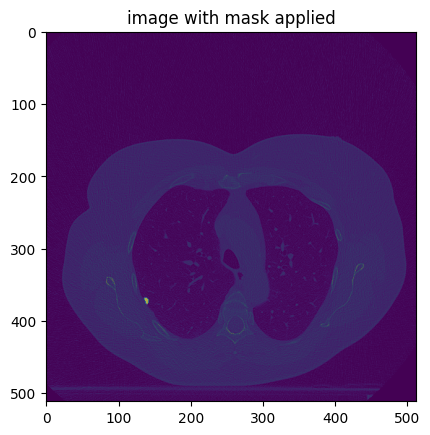

In [7]:
img = train_df['hu_array_old'][0]
mask = train_df['mask'][0]
plt.imshow(img)
plt.imshow(mask, alpha = 0.6)
plt.title("image with mask applied")
plt.show()

In [6]:
class CustomDataset(Dataset):
    def __init__(self, images, masks, transforms=None):
        self.images = images
        self.masks = masks
        self.transforms = transforms

    def __getitem__(self, index):
        image = self.images[index]  # Directly access the NumPy array
        image = np.asarray(image).astype('uint8')#.reshape(512, 512, 1)
        
        mask = self.masks[index]
        mask = np.asarray(mask).astype('uint8')#.reshape(512, 512, 1)

        transformed_image = self.transforms(image)
        return transformed_image, mask

    def __len__(self):
        return len(self.images)

transform = transforms.Compose([
    transforms.ToPILImage(),
    #transforms.Resize((128,128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_images = (train_df['hu_array_old'].values)
train_masks = (train_df['mask'].values)
test_images = (test_df['hu_array_old'].values)
test_masks = (test_df['mask'].values)

train_data = CustomDataset(train_images, train_masks, transform)
trainloader = DataLoader(train_data, batch_size=12, shuffle=False)

test_data = CustomDataset(test_images, test_masks, transform)
testloader = DataLoader(test_data, batch_size=12, shuffle=False)


In [7]:
# Load the pre-trained DeepLabV3 model
model = models.deeplabv3_resnet50(pretrained=True)

# Modify the classifier and aux_classifier layers
in_channels = 1  # Grayscale input
out_channels = 1  # Single-channel output (binary segmentation)

model.classifier[4] = torch.nn.Conv2d(256, out_channels, kernel_size=(1, 1), stride=(1, 1))
model.backbone.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
model.aux_classifier[4] = torch.nn.Conv2d(256, out_channels, kernel_size=(1, 1), stride=(1, 1))

model.cuda()


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/deeplabv3_resnet50_coco-cd0a2569.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet50_coco-cd0a2569.pth
100%|██████████| 161M/161M [00:01<00:00, 138MB/s]  


DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

In [8]:
# Loss function (Dice loss)
class DiceLoss(nn.Module):
    def __init__(self, smooth=1.0):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, inputs, targets):
        intersection = torch.sum(inputs * targets)
        union = torch.sum(inputs) + torch.sum(targets) + self.smooth
        dice = (2.0 * intersection + self.smooth) / union
        return 1.0 - dice

criterion = DiceLoss()

In [9]:
# Train the model
# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.01)

train_predicted_masks = []

# Training loop
num_epochs = 20
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    total_loss = 0

    for batch in trainloader:
        inputs, masks = batch
        inputs, masks = inputs.cuda(), masks.cuda()

        optimizer.zero_grad()
        outputs = model(inputs)
        outputs = outputs["out"].squeeze(1)  # Remove channel dimension

        # Convert predictions to binary (0 or 1)
        predicted_masks = (outputs > 0.5).float()

        train_predicted_masks.append(predicted_masks.cpu())
        
        #Make Comparison Binary
        #outputs = (outputs > 0.5).float()
        #masks = (masks > 0.5).float()

        # Calculate loss
        loss = criterion(outputs, masks)
        total_loss += loss.item()

        loss.backward()
        optimizer.step()
        del predicted_masks,inputs,masks,outputs
        torch.cuda.empty_cache()


    avg_loss = total_loss / len(trainloader)
    print(f"Epoch {epoch+1}: Train Loss = {loss:.4f}")

Epoch 1: Train Loss = 0.9996
Epoch 2: Train Loss = 1.0000
Epoch 3: Train Loss = 1.0001
Epoch 4: Train Loss = 1.0006
Epoch 5: Train Loss = 0.9963
Epoch 6: Train Loss = 0.9985
Epoch 7: Train Loss = 0.9986
Epoch 8: Train Loss = 0.9985
Epoch 9: Train Loss = 0.9984
Epoch 10: Train Loss = 0.9987
Epoch 11: Train Loss = 0.9984
Epoch 12: Train Loss = 0.9976
Epoch 13: Train Loss = 0.9984
Epoch 14: Train Loss = 0.9975
Epoch 15: Train Loss = 0.9982
Epoch 16: Train Loss = 0.9964
Epoch 17: Train Loss = 0.9945
Epoch 18: Train Loss = 0.9949
Epoch 19: Train Loss = 0.9285
Epoch 20: Train Loss = 0.7440


In [18]:
print (len(train_predicted_masks))

1180


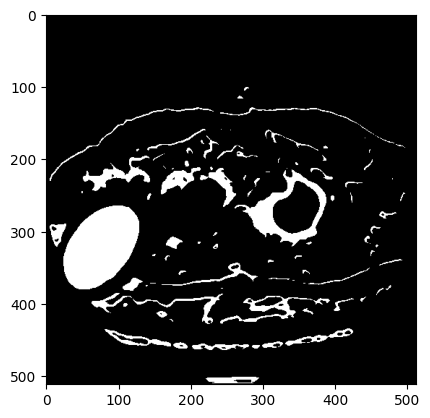

In [25]:
plt.imshow(train_predicted_masks[550][11], cmap='gray')